# Context

Multi-optimization problems are present in all companies, from balancing spending with future income to logitistic supply chains with production. Each problem is different though and may seek to optimize different objectives while accounting for different constraints.

In the examples from Pernod Ricard:
- the machine learning regression computing individual advertising contributions to sales volumes leads to a high-stakes decision making process where millions of euros need to be attributed to different channels in order to fulfill business objectives.
- 5 European countries have more than 500 people conducting upwards of 4000 weekly visits. These visits have to maximize potential impact while reducing the time/distance required to achieve these visits (or transportation and associated costs in other companies).

Gurobi is a company with a number of APIs which handle specific use cases with high performance algorithms and which is expensive to use.

Pymoo is an open-source and highly customizable package with a large number of algorithms which can be implemented and tailored to the individual use cases.

# Optimization problem

This problem will seek to fix the current French budget instead of waiting for the government to figure it out :-).


# Imports

In [55]:
%load_ext memory_profiler
import pandas as pd
import numpy as np

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.ctaea import CTAEA
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.visualization.scatter import Scatter
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.core.population import Population
from pymoo.core.algorithm import Algorithm
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.optimize import minimize


from pymoo.indicators.hv import Hypervolume
from pymoo.indicators.gd import GD
from pymoo.indicators.igd import IGD
from tabulate import tabulate

import matplotlib.pyplot as plt
import plotly.graph_objects as go


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Define the problem

In [56]:
class FranceBudgetProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=3,
                         n_obj=3,
                         n_constr=1,
                         xl=np.array([0, 0, 0]),
                         xu=np.array([100, 100, 100]))

    def _evaluate(self, x, out, *args, **kwargs):
        # Decision variables
        infrastructure_spending = x[0]
        tax_rate = x[1]
        social_spending = x[2]

        # Objectives
        f1 = -1 * (0.5 * infrastructure_spending - 0.3 * tax_rate)  # Maximize economic growth
        f2 = 0.7 * infrastructure_spending + social_spending - 0.8 * tax_rate  # Minimize budget deficit
        f3 = -1 * (0.6 * social_spending - 0.2 * tax_rate)  # Maximize social welfare

        out["F"] = [f1, f2, f3]

        # Constraint: Total spending <= 150
        out["G"] = infrastructure_spending + social_spending - 150

# Create the problem
problem = FranceBudgetProblem()
results=[]

# Optimization algorithms

## NSGA-II 


Results for nsga2:
Best solutions found: 
Solution 1: [4.98348002e+01 4.01736038e-02 9.99985022e+01]
Solution 2: [6.49700224e-04 9.99999755e+01 3.77371177e-02]
Solution 3: [1.25027253e+01 3.59648148e-04 9.99973977e+01]


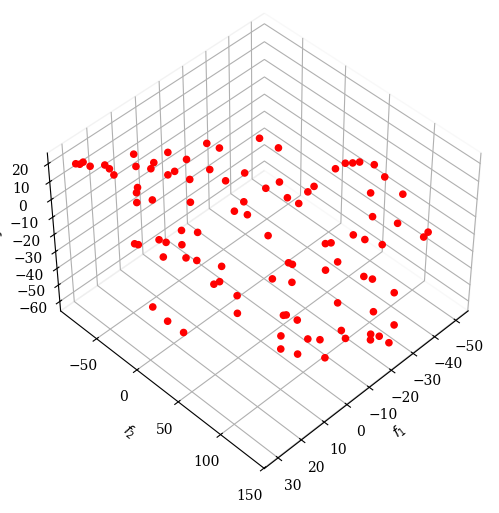

In [57]:
nsga2=NSGA2(pop_size=100)
res = minimize(problem,
                   nsga2,
                   ("n_gen", 100),
                   seed=1,
                   verbose=False)

results.append(("nsga2",res.F))

print(f"\nResults for nsga2:")
print(f"Best solutions found: \nSolution 1: {res.X[0]}")
print(f"Solution 2: {res.X[1]}")
print(f"Solution 3: {res.X[2]}")
# print(f"Objectives: {res.F}")

# Visualization
plot = Scatter()
plot.add(res.F, color="red", label="nsga2")
plot.show()

## NSGA-III


Results for nsga3:
Best solutions found: 
Solution 1: [ 0.1054921  99.99975091 71.64052584]
Solution 2: [57.5002054  79.36207574 33.17196341]
Solution 3: [2.07146700e-02 9.99805864e+01 9.34665853e+01]
Objectives: [[ 29.94717922  -8.28543042 -22.98436532]
 [ -4.94147998   9.93244659  -4.0307629 ]
 [ 29.9838186   13.49661643 -36.0838339 ]]


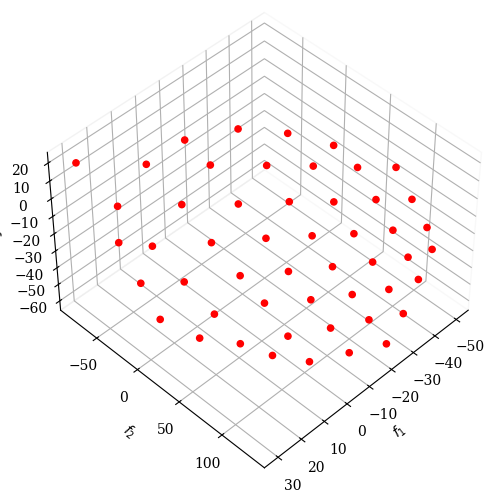

In [58]:
# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

nsga3=NSGA3(pop_size=100,ref_dirs=ref_dirs)
res = minimize(problem,
                   nsga3,
                   ("n_gen", 100),
                   seed=1,
                   verbose=False)

results.append(("nsga3",res.F))

print(f"\nResults for nsga3:")
print(f"Best solutions found: \nSolution 1: {res.X[0]}")
print(f"Solution 2: {res.X[1]}")
print(f"Solution 3: {res.X[2]}")
print(f"Objectives: {res.F[:3]}")

# Visualization
plot = Scatter()
plot.add(res.F, color="red", label="nsga3")
plot.show()

## CTAEA


Results for ctaea:
Best solutions found: 
Solution 1: [ 2.20643779 92.48230732 53.93160761]
Solution 2: [4.87133815e+01 5.64817735e-02 9.99600031e+01]
Solution 3: [13.4481577  93.32321462 13.29427729]


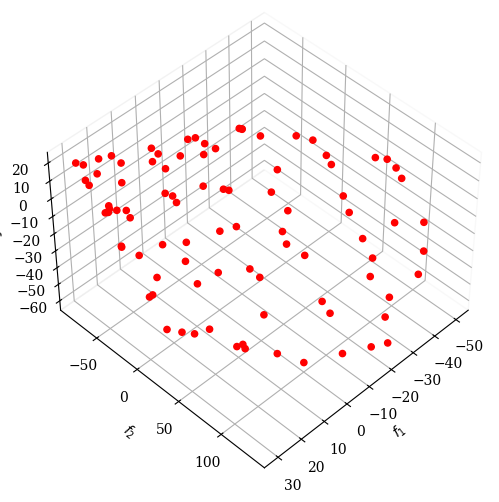

In [59]:
# create the reference directions to be used for the optimization
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

ctaea=CTAEA(n_neighbors=15, decomposition="auto", ref_dirs=ref_dirs)
res = minimize(problem,
                   ctaea,
                   ("n_gen", 100),
                   seed=1,
                   verbose=False)

results.append(("ctaea",res.F))

print(f"\nResults for ctaea:")
print(f"Best solutions found: \nSolution 1: {res.X[0]}")
print(f"Solution 2: {res.X[1]}")
print(f"Solution 3: {res.X[2]}")
# print(f"Objectives: {res.F}")

# Visualization
plot = Scatter()
plot.add(res.F, color="red", label="ctaea")
plot.show()

## Particle Swarm Optimization

In [60]:
class ThreeDProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=3, n_obj=3, xl=np.array([-5,-5,-5]), xu=np.array([5,5,5]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = -1 * (0.5 * x[0] - 0.3 * x[1])  # Maximize economic growth
        f2 = 0.7 * x[0] + x[2] - 0.8 * x[1]  # Minimize budget deficit
        f3 = -1 * (0.6 * x[2] - 0.2 * x[1])  # Maximize social welfare
        out["F"] = [f1, f2,f3]


class MOPSO(Algorithm):
    def __init__(self, pop_size=100, w=0.9, c1=2.0, c2=2.0, **kwargs):
        super().__init__(**kwargs)
        self.pop_size = pop_size
        self.w = w
        self.c1 = c1
        self.c2 = c2

    def _initialize_infill(self):
        X = np.random.uniform(self.problem.xl, self.problem.xu, size=(self.pop_size, self.problem.n_var))
        return Population.new(X=X)

    def _initialize_advance(self, infills=None, **kwargs):
        self.pop = infills
        self.velocities = np.zeros((self.pop_size, self.problem.n_var))
        self.pbest = self.pop.copy()
        self.gbest = self.pop[np.random.randint(self.pop_size)]

    def _infill(self):
        X = self.pop.get("X")
        
        r1, r2 = np.random.random((2, self.pop_size, self.problem.n_var))
        
        self.velocities = (self.w * self.velocities +
                           self.c1 * r1 * (self.pbest.get("X") - X) +
                           self.c2 * r2 * (self.gbest.get("X") - X))
        
        X = X + self.velocities
        X = np.clip(X, self.problem.xl, self.problem.xu)
        
        return Population.new(X=X)

    def _advance(self, infills=None, **kwargs):
        self.pop = infills
        
        # Update personal best
        for i in range(self.pop_size):
            if self.dominate(self.pop[i], self.pbest[i]):
                self.pbest[i] = self.pop[i]
        
        # Update global best
        non_dominated = self.non_dominated(self.pbest)
        if len(non_dominated) > 0:
            self.gbest = non_dominated[np.random.randint(len(non_dominated))]

    def dominate(self, a, b):
        return np.all(a.F <= b.F) and np.any(a.F < b.F)

    def non_dominated(self, pop):
        F = pop.get("F")
        non_dominated_indices = NonDominatedSorting().do(F, only_non_dominated_front=True)
        return pop[non_dominated_indices]

    def _set_optimum(self):
        self.opt = self.non_dominated(self.pop)

Best solutions found:
X = [[-5.          5.          3.97403974]
 [-0.2215099  -2.00325437 -5.        ]
 [-0.24149192  5.         -0.03066816]]
F = [[ 4.         -3.52596026 -1.38442384]
 [-0.49022136 -3.55245343  2.59934913]
 [ 1.62074596 -4.1997125   1.01840089]]


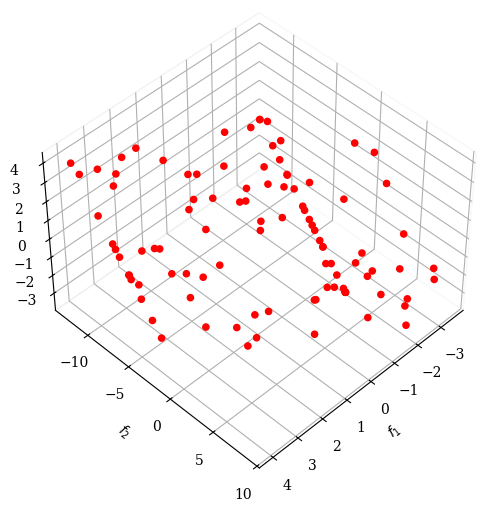

In [61]:
problem = ThreeDProblem()

# Algorithm setup
algorithm = MOPSO(
    pop_size=100,
    eliminate_duplicates=True
)

# Run optimization process
res = minimize(problem,
               algorithm,
               ('n_gen', 100),
               seed=1,
               verbose=True)

results.append(("mopso",res.F))

# Display results
print("Best solutions found:")
print("X =", res.X[:3])
print("F =", res.F[:3])

# Visualization
plot = Scatter()
plot.add(res.F, color="red", label="ctaea")
plot.show()

## Differential Evolution

In [62]:
class MODE(Algorithm):

    def __init__(self,
                 pop_size=100,
                 F=0.5,
                 CR=0.5,
                 **kwargs):
        super().__init__(**kwargs)
        self.pop_size = pop_size
        self.F = F
        self.CR = CR

    def _setup(self, problem, **kwargs):
        self.problem = problem

    def _initialize_infill(self):
        X = np.random.uniform(self.problem.xl, self.problem.xu, size=(self.pop_size, self.problem.n_var))
        return Population.new(X=X)

    def _infill(self):
        pop = self.pop
        X = pop.get("X")
        
        off = np.full(X.shape, np.inf)

        for i in range(self.pop_size):
            a, b, c = np.random.choice(self.pop_size, 3, replace=False)
            
            v = X[a] + self.F * (X[b] - X[c])
            
            j = np.random.randint(self.problem.n_var)
            for k in range(self.problem.n_var):
                if np.random.random() < self.CR or k == j:
                    off[i, k] = v[k]
                else:
                    off[i, k] = X[i, k]
        
        off = np.clip(off, self.problem.xl, self.problem.xu)

        return Population.new(X=off)

    def _advance(self, infills=None, **kwargs):
        # Merge parents and offspring
        pop = Population.merge(self.pop, infills)

        # Perform non-dominated sorting
        F = pop.get("F")
        fronts = NonDominatedSorting().do(F)

        # Select the next population
        next_pop = []
        for front in fronts:
            if len(next_pop) + len(front) <= self.pop_size:
                next_pop.extend(front)
            else:
                # If adding the entire front exceeds pop_size, we need to select a subset
                remaining = self.pop_size - len(next_pop)
                # Here we could implement a crowding distance selection, but for simplicity, we'll use random selection
                selected = np.random.choice(front, remaining, replace=False)
                next_pop.extend(selected)
                break

        self.pop = pop[next_pop]

    def _set_optimum(self, **kwargs):
        F = self.pop.get("F")
        non_dominated = NonDominatedSorting().do(F, only_non_dominated_front=True)
        self.opt = self.pop[non_dominated]

Best solutions found:
X = [-1.87460806 -4.40212077 -4.92548926]
F = [-0.3833322  -2.71601829  2.0748694 ]


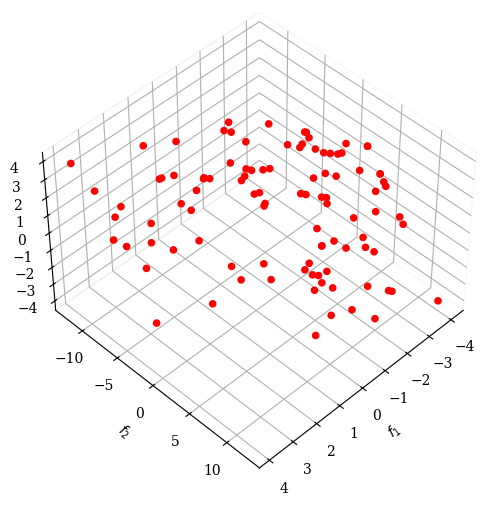

In [63]:
# Problem definition
problem = ThreeDProblem()

# Algorithm setup
algorithm = MODE(
    pop_size=100,
    eliminate_duplicates=True
)

# Run optimization process
res = minimize(problem,
               algorithm,
               ('n_gen', 100),
               seed=1,
               verbose=True)

results.append(("mode",res.F))

# Display results
print("Best solutions found:")
print("X =", res.X[0])
print("F =", res.F[0])

# Visualization
plot = Scatter()
plot.add(res.F, color="red", label="ctaea")
plot.show()

## SPEA2


Results for spea2:
Best solutions found: 
Solution 1: [-4.95003467 -2.17917251 -4.95343153]
Solution 2: [4.75085357 1.35588272 1.69591073]
Solution 3: [4.46725157 2.50991319 2.98770299]
Objectives: [ 1.82126558 -6.67511779  2.53622442]


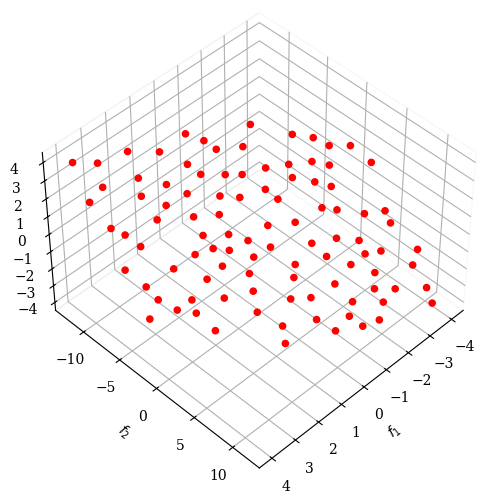

In [64]:
spea2=SPEA2(pop_size=100)
res = minimize(problem,
                   spea2,
                   ("n_gen", 100),
                   seed=1,
                   verbose=False)

results.append(("spea2",res.F))

print(f"\nResults for spea2:")
print(f"Best solutions found: \nSolution 1: {res.X[0]}")
print(f"Solution 2: {res.X[1]}")
print(f"Solution 3: {res.X[2]}")
print(f"Objectives: {res.F[0]}")

# Visualization
plot = Scatter()
plot.add(res.F, color="red", label="spea2")
plot.show()

## Metrics

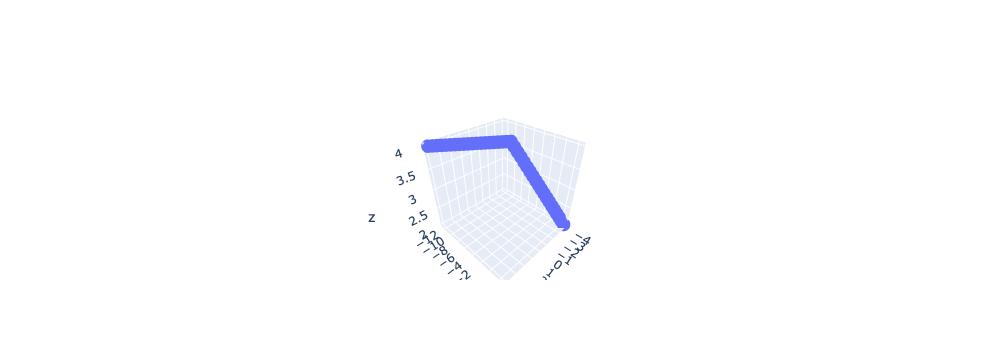

In [65]:
class MyProblem:
    def __init__(self):
        pass

    def evaluate(self, x):
        f1 = -1 * (0.5 * x[0] - 0.3 * x[1])  # Maximize economic growth
        f2 = 0.7 * x[0] + x[2] - 0.8 * x[1]  # Minimize budget deficit
        f3 = -1 * (0.6 * x[2] - 0.2 * x[1])  # Maximize social welfare
        return np.array([f1, f2, f3])

    def pareto_front(self, n_points=20):
        # Generate points for the true Pareto front
        
        # Generate candidate solutions
        x0 = np.linspace(-5, 5, n_points)
        x1 = np.linspace(-5, 5, n_points)
        x2 = np.linspace(-5, 5, n_points)
        X0, X1, X2 = np.meshgrid(x0, x1, x2)
        
        # Evaluate objectives
        F1 = -1 * (0.5 * X0 - 0.3 * X1)
        F2 = 0.7 * X0 + X2 - 0.8 * X1
        F3 = -1 * (0.6 * X2 - 0.2 * X1)
        
        # Flatten arrays
        F1_flat = F1.flatten()
        F2_flat = F2.flatten()
        F3_flat = F3.flatten()
        
        # Combine objectives and filter non-dominated solutions
        combined = np.vstack((F1_flat, F2_flat,F3_flat)).T
        
        # Non-dominated sorting to find Pareto front
        is_dominated = np.zeros(combined.shape[0], dtype=bool)
        
        for i in range(combined.shape[0]):
            for j in range(combined.shape[0]):
                if i != j:
                    if (combined[j][0] <= combined[i][0]) and (combined[j][1] < combined[i][1]):
                        is_dominated[i] = True
                        break
        
        pareto_front = combined[~is_dominated]
        
        return pareto_front

# Create an instance of your problem
problem = MyProblem()

# Calculate true Pareto front
true_pareto_front = problem.pareto_front()
temp=pd.DataFrame(true_pareto_front,columns=["x","y","z"])
# Visualization
fig = go.Figure(data=go.Scatter3d(x=temp["x"],y=temp["y"],z=temp["z"], mode='markers'))
fig.show()

In [66]:
# Calculate metrics
metrics = {
    "Hypervolume": Hypervolume(ref_point=np.array([10, 10,10])),
    "GD": GD(true_pareto_front),
    "IGD": IGD(true_pareto_front),
}

# Calculate metrics for each algorithm
data = []
for item in results:
    row = [item[0]]
    for metric_name, metric in metrics.items():
        if metric_name == "Hypervolume":
            value = metric.do(item[1])
        else:
            value = metric.do(item[1], true_pareto_front)
        row.append(f"{value:.4f}")
    data.append(row)

# Create table
headers = ["Algorithm"] + list(metrics.keys())
table = tabulate(data, headers=headers, tablefmt="grid")

print(table)

TypeError: _do() takes 2 positional arguments but 3 were given